### 导入相关库并设置所需全局变量

1. 导入运行本项目所需的库。

2. 设置device全局变量，指定模型和张量的计算设备，判断设备是否支持CUDA并使用GPU进行加速计算，否者使用CPU。

In [1]:
import torch
from torchvision import transforms
from torchvision import datasets
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# 相关函数/方法

# torch.device('cpu/cuda/cuda:device_index')指定模型和张量的计算设备
# 注意模型和张量的设备一致性，在进行训练或推理时，需确保模型和张量在同一个设备上

# torch.cuda.is_available()检查当前系统是否支持CUDA，是否有可用GPU设备，判断当前环境是否可使用GPU进行加速计算

### 图像变换组合

1. 将多个图像变换函数/方法组合在一起。

2. 将图像数据转为张量。

3. 对图像张量进行标准化。

注意：

- 在手写数字识别项目中，经常使用标准化参数transforms.Normalize((0.1307,), (0.3081,))，对应MNIST数据集的全局均值和标准差，通过对MNIST数据集进行统计计算得到。

In [3]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
print(transforms)

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)


In [4]:
# 相关函数/方法

# Compose()组合多个图像变换操作，允许将多个变换操作串联起来，形成一个完整的预处理流程，简化数据预处理的步骤
# transforms(list of Transform objects)一个包含多个变换操作的列表，每个变换操作都是一个Transform对象
# 变换操作会按照列表中出现的顺序依次执行

# ToTensor()将PIL图像或NumPy数组转为PyTorch张量的无参变换操作，转换后的张量是浮点张量，范围在[0.0, 1.0]
# 对于PIL图像，图像通道顺序从(H, W, C)转为(C, H, W)，H高度，W宽度，C通道数
# 对于NumPy数组，数组形状从(H, W, C)或(H, W)转为(C, H, W)或(1, H, W)灰度图
# 将图像像素值从[0, 255]归一化到[0.0, 1.0]，通过将每个像素值除以255.0实现

# Normalize()对图像张量进行归一化处理的变换操作，确保输入数据的分布符合模型训练时的期望分布
# mean(sequence)序列，包含每个通道的均值，对于RGB图像，通常是一个长度为3的列表或元组，分别对应R、G、B通道的均值
# std(sequence)序列，包含每个通道的标准差，对于RGB图像，通常是一个长度为3的列表或元组，分别对应R、G、B通道的标准差

### 下载和加载数据集并进行图像变换

注意：

- MNIST数据集，训练集包含60000张图像及其对应标签，测试集包含10000张图像及其对应标签，每个图像对应一个0-9的数字标签，每张图像为28×28像素的灰度图像，像素值范围为0-255。

In [5]:
train_dataset = datasets.MNIST(root='C:\\Users\\kongbai\\study\\dataset', train=True, transform=transforms, download=True)
test_dataset = datasets.MNIST(root='C:\\Users\\kongbai\\study\\dataset', train=False, transform=transforms, download=True)
print(len(train_dataset))
print(len(test_dataset))
feature, label = train_dataset[0]
print(feature.size())
print(label)
feature, label = test_dataset[0]
print(feature.size())
print(label)

60000
10000
torch.Size([1, 28, 28])
5
torch.Size([1, 28, 28])
7


In [6]:
# 相关函数/方法

# MNIST()加载MNIST数据集
# root(str or pathlib.Path)数据集根目录，数据集将被下载到此目录下的MNIST/raw子目录中
# train(bool, optional)为True，则加载训练集数据，为False，则加载测试集数据，默认为True
# transform(callable, optional)一个函数或转换，对输入图像进行预处理
# target_transform(callable, optional)一个函数或转换，对目标标签进行预处理
# download(bool, optional)为True，则从互联网下载数据集并将其保存到root目录中，如果已经下载，则不会再次下载，默认为False

### 展示数据

注意：

- 对于datasets.MNIST对象，data属性包含所有图像数据的张量，targets属性包含所有图像数据的标签。

- data的形状通常为(num_samples, height, width)，num_samples数据集样本数量，height，width图像高度和宽度。

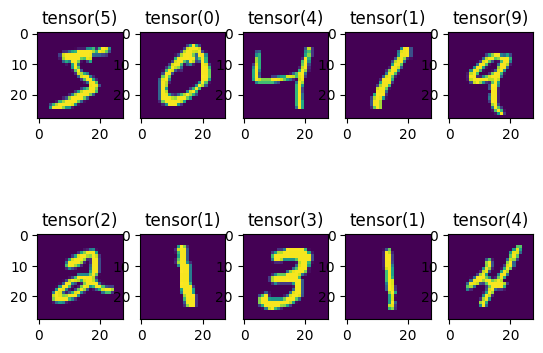

In [7]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_dataset.data[i])
    plt.title(train_dataset.targets[i])
plt.show()

### 创建数据迭代器

1. 指定批量大小和是否在每个epoch开始时打乱数据集，创建数据迭代器，便于模型在训练和预测过程中循环迭代。

In [8]:
batch_size = 64
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
print(len(train_loader))
print(len(test_loader))

938
157


### 定义模型

模型基于CNN卷积层和全连接神经网络层。

1. Conv2d()卷积层，实现二维卷积操作。

2. MaxPool2d(kernel_size=2)汇聚层，实现二维最大汇聚。

3. Linear()全连接神经网络层，将输入数据映射到新的特征空间，从而提取更高层次的特征，增加模型复杂度，提高模型表达能力，执行分类任务。

4. ReLU激活函数，引入非线性因素，增强模型表达能力。

5. x = x.view(x.size(0), -1)将数据从高维转为一维，便于全连接神经网络层计算。

注意：

- 通过多层全连接层和激活函数，以实现非线性变换，逐步提取高层次特征并最终输出预测结果。

- 作者认为ReLU激活函数非常适合处理灰度图像。

- 模型最后的输出并没有使用类似Softmax激活函数功能的变换，因为CrossEntropyLoss()损失函数可自动实现，不必重复实现，但在预测阶段要对模型输出进行处理。

- 没有手动初始化模型中网络的任何参数，均使用默认的自动初始化。

- 模型还可改造，还可添加其他正则化层，批量规范化层，其他需要的网络层等。

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc2(self.fc1(x))
        return x

### 初始化模型

1. 根据设备硬件情况，可将模型创建在指定设备上运行。

In [10]:
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### 定义损失函数和优化器并初始化

1. 损失函数使用CrossEntropyLoss()，用于分类问题的损失函数，结合了softmax层和负对数似然损失，衡量模型预测的概率分布与真实标签之间的差异。

2. 优化器使用Adam()，自适应学习率优化算法，结合了动量法和自适应学习率调整，能在训练模型时自动调整每个参数的学习率，有效加速收敛并提高模型性能。

注意：

- 可指定其他损失函数和优化器。

In [11]:
Loss = nn.CrossEntropyLoss()
print(Loss)
 
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### 训练模型

1. 将模型转为训练模式，在训练模式下，某些特定的层会表现出与评估模式不同的行为。

2. 指定训练轮数，使用训练轮数和数据集迭代，根据设备硬件情况，可将张量移动到指定设备上进行计算，清除上一次计算的梯度，将特征输入到模型中，计算损失，根据损失计算梯度，更新模型参数。

3. 指定每50次打印一次损失值，每个批次结束后也打印。

In [12]:
net.train()
epochs = 2
for epoch in range(epochs):
    i = 1
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(features)
        loss = Loss(outputs, labels)
        loss.backward()
        optimizer.step()
        i += 1
        if i % 50 == 0:
            print(f'第{epoch+ 1}轮，第{i}个损失：{loss}')
    print(f'第{epoch +1}轮最后一次损失：{loss}')

第1轮，第50个损失：0.4163380563259125
第1轮，第100个损失：0.30608832836151123
第1轮，第150个损失：0.26262763142585754
第1轮，第200个损失：0.09104130417108536
第1轮，第250个损失：0.1488879919052124
第1轮，第300个损失：0.12535300850868225
第1轮，第350个损失：0.1207946389913559
第1轮，第400个损失：0.09407723695039749
第1轮，第450个损失：0.039975568652153015
第1轮，第500个损失：0.22217296063899994
第1轮，第550个损失：0.08858702331781387
第1轮，第600个损失：0.21817658841609955
第1轮，第650个损失：0.023805717006325722
第1轮，第700个损失：0.11840132623910904
第1轮，第750个损失：0.05590895563364029
第1轮，第800个损失：0.2893139719963074
第1轮，第850个损失：0.05964411795139313
第1轮，第900个损失：0.26141637563705444
第1轮最后一次损失：0.06759467720985413
第2轮，第50个损失：0.11793167144060135
第2轮，第100个损失：0.04639267921447754
第2轮，第150个损失：0.041050877422094345
第2轮，第200个损失：0.029828764498233795
第2轮，第250个损失：0.019942084327340126
第2轮，第300个损失：0.04282733052968979
第2轮，第350个损失：0.006816410925239325
第2轮，第400个损失：0.08878619223833084
第2轮，第450个损失：0.03647296875715256
第2轮，第500个损失：0.08029617369174957
第2轮，第550个损失：0.04987139627337456
第2轮，第600个损失：0.09758511185646057
第2轮，第650个损

### 模型预测

1. 将模型转为评估模式，关闭训练时特有的层，确保在预测数据上获得一致且可重复的结果。

2. 定义模型精度计算参数，计算模型在测试数据上的精确率。

3. 根据设备硬件情况，可将张量移动到指定设备上进行计算，禁用梯度计算，防止模型内部参数变化。

In [13]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = net(features)
        _, predicted= torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc = correct / total
print(f'acc：{acc}')

acc：0.9828
